In [1]:
"""
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import pandas as pd
from utils.plotting import *

import warnings
warnings.filterwarnings('ignore')

repo_path = '/Users/marinasiebold/Library/Mobile Documents/com~apple~CloudDocs/Studium/Bird_Research/Rbeast/Python/py_src'
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

print(sys.path)
import Rbeast
"""

"\n%reload_ext autoreload\n%autoreload 2\n\nimport sys\nsys.path.append('../')\n\nimport pandas as pd\nfrom utils.plotting import *\n\nimport warnings\nwarnings.filterwarnings('ignore')\n\nrepo_path = '/Users/marinasiebold/Library/Mobile Documents/com~apple~CloudDocs/Studium/Bird_Research/Rbeast/Python/py_src'\nif repo_path not in sys.path:\n    sys.path.insert(0, repo_path)\n\nprint(sys.path)\nimport Rbeast\n"

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import Rbeast as rb
import pandas as pd
from utils.plotting import *

import contextlib, io

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '../../../01_Data/datasets/time_series_27_species_week_counts.csv'
#path = '../../../01_Data/datasets/time_series_feldsperling_week_counts.csv'
df = pd.read_csv(path)

In [4]:
species = 'Bergente'
grid_id = '50kmE4500N3450'
bird = df[(df['name_species'] == species) & (df['eea_grid_id'] == grid_id)]
# plot_sighting_ratios_over_year(bird, title='Icterine warbler (Gelbspötter) sighting ratios in grid 50kmE4350N3250')

INFO: '2018-01-01' interpreted as 2018-01-01 (Y-M-D)



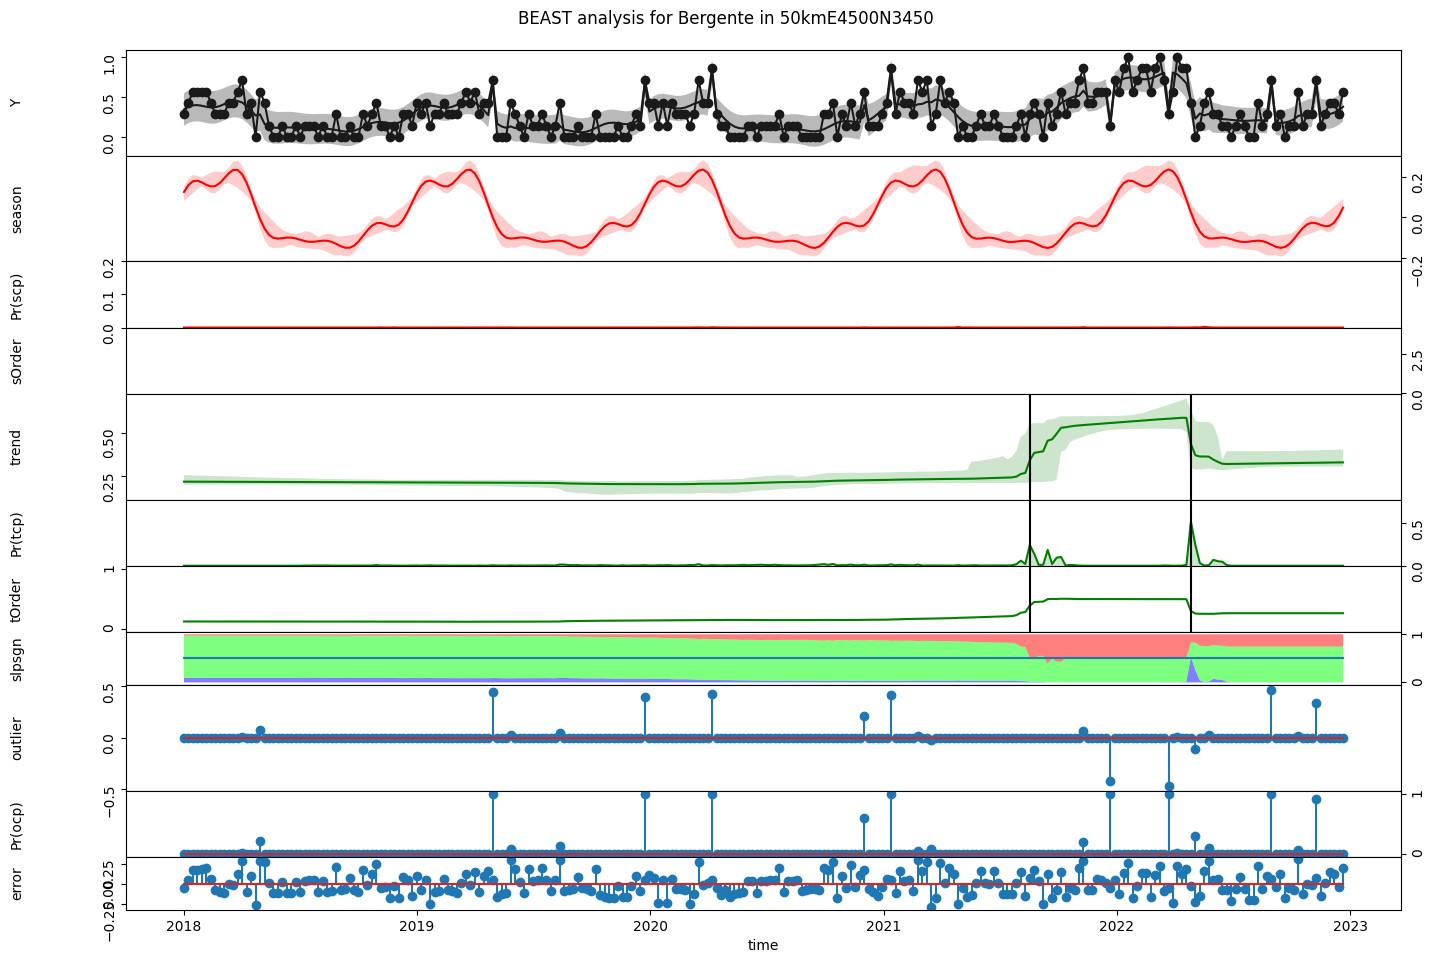

In [5]:
o = rb.beast(bird.sighting_ratio, deltat='7 days', period='1 year',
             start='2018-01-01', end='2022-12-31',
             hasOutlier=True, print_options=False, print_progress=False)
fig = plt.figure(figsize=(15, 10))
fig = rb.plot(o, fig=fig, title=f'BEAST analysis for {species} in {grid_id}')

In [6]:
num_cp = int(o.trend.ncp_median)
print(f'Number of change points: {num_cp}')
print('Changepoint location:', o.trend.cp[:num_cp])
print('Changepoint prob:', o.trend.cpPr[:num_cp])

Number of change points: 2
Changepoint location: [2022.3164 2021.626 ]
Changepoint prob: [0.99683326 0.9684583 ]


In [7]:
from datetime import datetime, timedelta

def decimal_year_to_datetime(decimal_year):
    year = int(decimal_year)
    remainder = decimal_year - year
    start_of_year = datetime(year, 1, 1)
    start_of_next_year = datetime(year + 1, 1, 1)
    year_duration = start_of_next_year - start_of_year
    date_time = start_of_year + timedelta(seconds=remainder * year_duration.total_seconds())
    return date_time


### **Changepoint map of a Bergente**

#### Calculate change points

In [8]:
species = 'Bergente'

In [9]:
bird = df[df['name_species'] == species]
all_grids = bird.eea_grid_id.unique()

In [ ]:
results = []
for grid in all_grids[:2]:
    slice = bird[bird['eea_grid_id'] == grid]
    o = rb.beast(slice.sighting_ratio,
                    deltat='7 days', period='1 year',
                    start='2018-01-01', end='2022-12-31',
                    hasOutlier=True, print_options=False, print_progress=False)
    num_cp = int(o.trend.ncp_median)
    timestamps = [decimal_year_to_datetime(dy).strftime('%d-%m-%Y') for dy in o.trend.cp[:num_cp]]
    probs = [round(prob, 3) for prob in o.trend.cpPr[:num_cp]]
    results.append({
        'species': species,
        'grid_id': grid,
        'num_cp': num_cp,
        'timestamps': timestamps,
        'probs': probs
    })

beast_results = pd.DataFrame(results)
beast_results

#### Load grid info

In [ ]:
import geopandas as gpd

eea_shapefile_path = '../../../01_Data/shp_files/grids/eea_europe_grids_50km/inspire_compatible_grid_50km.shp'
eea_grid = gpd.read_file(eea_shapefile_path)
eea_grid = eea_grid.to_crs('EPSG:4326')

germany_switzerland_bbox = eea_grid.cx[5.210942:15.669926, 45.614516:55.379499]
eea_grid_filtered = eea_grid[eea_grid.intersects(germany_switzerland_bbox.unary_union)]
eea_grid_filtered.rename(columns={'cellcode': 'grid_id'}, inplace=True)
eea_grid_filtered.reset_index(drop=True, inplace=True)

In [ ]:
merged_df = pd.merge(beast_results, eea_grid_filtered, on='grid_id')
merged_df = merged_df[['species', 'num_cp', 'timestamps', 'probs', 'geometry', 'grid_id']]

gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs='EPSG:4326')
gdf = gdf.reset_index(drop=True)
gdf

In [ ]:
import geopandas as gpd
import plotly.express as px


gdf['num_cp'] = gdf['num_cp'].astype(str)

# Create a custom color mapping
color_discrete_map = {
    '0': 'green',  # Green for 0
    '1': 'yellow',  # Yellow for 1
    '2': 'orange',  # Orange for 2
    '3': 'red',  # Red for 3 or more
}

# Create the plot using Plotly Express
fig = px.choropleth_mapbox(
    gdf, 
    geojson=gdf, 
    locations=gdf.index, 
    color="num_cp",
    color_discrete_map=color_discrete_map,  # Use custom discrete color map
    center={"lat": gdf.geometry.centroid.y.mean(), "lon": gdf.geometry.centroid.x.mean()},
    zoom=10,
    opacity=0.5,
    hover_data={'timestamps': False, 'probs': True, 'num_cp': True},
)


# Update the layout to match your specified layout
fig.update_layout(
    mapbox=dict(
        style='open-street-map',
        zoom=4
    ), 
    showlegend=True,  # Show the legend
    margin=dict(l=0, r=0, t=0, b=0)
)

fig.update_traces(marker_line_width=0)

# Show the plot
fig.show()
